In [1]:
import numpy as np
import matplotlib.pyplot as plt

# A quick note on notation and shape 

- For most of this section we are going to be talking about 2-D gridded data with a temporal dimension
- In general, this will be something like $F_{ij}(t)$, where $F_{ij}$ is located at $x_i$, $y_j$. This means that $A$ is essentially a matrix at every point in time, or a 3 dimensional array.
- Very often it will make more sense to treat a gridded data product like a 2-D matrix, e.g. we want something like: $$ X  = \begin{pmatrix} X_{0}(t_1) &  X_{0}(t_2) & \cdots X_{0}(t_m) \\ 
X_{1}(t_1) &  X_{1}(t_2) & \cdots x_{1}(t_m) \\
 & \vdots  &  \\
X_{n}(t_1) &  X_{n}(t_2) & \cdots X_{n}(t_m) \\
\end {pmatrix} $$ 
  - If $F$ has dimensions $n_x$ and $n_y$, then $X_{0}(t)=F_{0,0}(t)$, ... $X_{n_x}(t)=F_{n_x,0}(t)$, ... $X_{n_xn_y}(t)=F_{n_x,n_y}(t)$.
  - In numpy this can be done using the np.reshape command: ``` A=np.reshape(F,[nx*ny,nt]) ```  
  - If we calculate $AA^T$ this will be the same as calculating the temporal variance.
  - If the data is weighted equally by area, then calculating $A^T A$ will be the same thing as taking a spatial variance. 
- Often what we will do if we want to take something like a temporal variance with a gridded dataset is do something like: 
``` 
A=np.reshape(F,[nx*ny,nt])
C=np.dot(A,np.tranpose(A))
Cr = np.reshape(C,[nx,ny])
```
- The final output Cr will be a matrix of the temporal variances of shape $(n_x,n_y)$
- reshaping data in this way also has the effect of allowing us to apply matrix operations to the data. In particular, it makes sense to talk about things like eigenvectors and diagonalization. 
- So if in the notes you read something that is a matrix operation, the underlying datatset could be on a 1 dimensional grid, or it could be two dimensional and reshaped to be 1 dimensional. 

# 4.1 - Spatial Correlation and Field Significance
Most of this section comes from the excellent paper
-  Wilks, Daniels. "“The stippling shows statistically significant grid points”: How research results are routinely overstated and overinterpreted, and what to do about it." Bulletin of the American Meteorological Society 97.12 (2016): 2263-2273.

The rest comes from 
- DelSole, Timothy, and Michael Tippett. Statistical methods for climate scientists. Cambridge University Press, 2022. Chapter 13

## Spatial Correlation maps 

- One trick which is commonly used to search for spatial patterns in data is to take the correlation of the entire dataset with a single time series. For instance if we have a single time series $s(t)$, we could calculate the correlation matrix between our datafield $X$ and $S$ at ever grid point. 
- If we chose $S$ to be one of the data points in $X$ this would be called point correlation.   

### Some Examples

The first figure shows the correlation between an ENSO index ($s$) and the Monthly Wintertime temperatures over north America ($X$). 


The second figure shows point correlations for two different points.

<img src="../images/NaiveCorrelationTest.png" width=100%, height=100%>

<img src="../images/PointCorrelation.png" width=100%, height=100%>

## Field Significance 

### The problem 

- As we've discussed multiple times it's harder to make statistical estimates when data is correlated. 
- For many large scale variables there are large correlation lengths, sometimes thousands of kilometers, which means that is not a good idea to treat all of our data as independent. 
- This is a problem when we want to do a hypothesis test at every grid point. If we just compute a test statistic at every grid point and compare it to one critical value this is equivalent to doing independent hypothesis tests at every grid point, which most of the time is overestimating how independent the data is. 
- In practice what will happen is that there are many datapoints that will falsely reject the null hypothesis. These false rejections will look significant, but will in fact not be significantly different from the null hypothesis. The rate of these datapoints where the null hypothesis is falsely rejected are called "False Discoverty Rate" or FDR.  

<img src="../images/CorrelationLengthScales.png" width=100%, height=100%>

### Controlling the False Discovery Rate 

- It turns out that the solution to this problem weirdly doesn't need the actual correlation length or anything similar. Instead there is a more general procedure which controls the FDR, which works even when the data is correlated. 
- The main idea of the procedure is to calculate the p-values for all of the tests, and then only accept tests which pass a certain threshold, which should vary depending on the number of tests. By controlling this threshold we are able to directly control the FDR.
-To describe this method in more detail:
  1. calculate p-values for all of grid points
  2. order the p-values from smallest to largest, so that they are in a set $$ p_1,p_2,...,p_k,...p_n $$
  3. calculate the sequence $$ \frac{\mathrm{FDR} 1} {n},\frac{\mathrm{FDR} 2} {n},...,\frac{\mathrm{FDR} k} {n},...\frac{\mathrm{FDR} n} {n} $$ where FDR is the desired FDR 
  4. compare the two series and find the largest index where $p_k<\frac{\mathrm{FDR} k} {n}$
  5. define a critical p-value $p^*$ using the index in the previous step
  6. reject the null hypothesis at any grid point where $p\leq p^*$ and accept the null hypothesis anywhere that $p>p^*$ 
- This method can be done using any statistical test. It is often applied when studying correlation or trends, but in theory it can applied to any well defined hypothesis test.

### An example

The first figure shows how the FDR can be controlled graphically, as done in the figure below. Note that although the FDR in the example is 0.1, the $p^*$ is something much less than 0.1. The line labelled "Benjami-Hochberg" is the sequence $\frac{\mathrm{FDR} k} {n}$.

The second figure shows the regions corresponding to the previous example of correlation between ENSO and DJF surface temperature where the null hypothesis can be rejected using a FDR=0.01. Compared to the previous figure there are large areas where the correlation looks large but where the null hypothesis cannot be rejected. 

<img src="../images/OrderedPvaluesTest.png" width=100%, height=100%>

<img src="../images/FieldSignificanceTest.png" width=100%, height=100%>


# 4.2 - Principle Component Analysis (PCA)

I said in the introductory lecture that PCA is one of the most misused ideas in statistics. This is because although the technique is very powerful, it has an inherent property that it will always produce patterns of correlation from the data, for reasons discussed below. This means that even in the lack of any meaningful physical or mechanistic process taking place PCA will always produce interesting patterns to study. I say this not to discourage you from using it, but simply to appreciate the challenges in applying a statistical technique. 

We won't have time to discuss *all* the ways that PCAs are sometimes misused in atmospheric and oceanic science, but there are a few papers from the references which cover the challenges in fairly exhaustive detail which I will reference as we go through the next couple of sections:

- Chen, Ge, and Xuan Wang. "Impact of domain geometry on the results of empirical orthogonal function analysis." Annals of GIS 20.3 (2014): 205-216.
- Monahan, Adam H., et al. "Empirical orthogonal functions: The medium is the message." Journal of Climate 22.24 (2009): 6501-6514.
- North, Gerald R., et al. "Sampling errors in the estimation of empirical orthogonal functions." Monthly weather review 110.7 (1982): 699-706.

A very interesting example of this from another field is the standard "IQ" test which is given in psychology. In an excellent book Stephen Gould argues that in fact the entire idea of intelligence comes from the misinterpretation of PCA: 

- Gould, Stephen Jay. Mismeasure of man. WW Norton & company, 1996.

## Principle Component Analysis as Diagonalization

- Recall that the eigenvectors and eigenvalues of a matrix can be used to diagonalize it:
$$ \begin{align*}
A\vec{p_i} &=& q_i \vec{p_i} \\
AP &=& QP \\
A  &=& PQP^{-1} 
\end{align*} $$

- Where we have defined $P=[\vec{p_1},...\vec{p_N}]$ and $Q$ is a diagonal matrix with entries of $q_i$. For a real symmetric matrix $PP^T = I$, which implies $P^T=P^{-1}$. 
- Suppose that we data defined at $n_x$ grid points. We can then define a data matrix as $X=[x_1(t),...,x_{n_x}(t)]$, and use it to form a covariance matrix: $$ C = XX^T$$
- The covariance matrix is always a real symmetric matrix, so it can always be diagonalized, using its eigenvectors and eigenvalues like above: $$ C = P^{-1} Q P $$
- If each data point represents an equally weighted area, then the total variance of the field is given by $$V=\mathrm{Tr}(C)$$, where $\mathrm{Tr}$ is the trace, or the sum of diagonal entries of the matrix. This is because each diagonal entry will be the covariance of 1 gridpoint and itself, or the variance of that gridpoint. By summing along the diagonal we are summing the variance of each gridpoint together.
- An important theorem from linear algebra states that $\mathrm{TR}(AB)=\mathrm{TR}(BA)$, so that $$\begin{align*}\mathrm{TR}(C)&=&\mathrm{TR}(PQP^-1)\\&=&\mathrm{TR}(QPP^-1)\\&=&\mathrm{TR}(Q)\end{align*}$$
  - This says that the total variance of our field is the same as the sum of the eigenvalues. So by finding the eigenvalues we have partioned up the total variance into a component associated with each eigenvalue. 
- The core idea of PCA analysis and EOFs is to find the spatial pattern and time series associated with each eigenvalue of $C$. This can be done as follows:

$$ \begin{align*}

C &=& XX^T \\
 P^{-1} Q P &=& XX^T \\
Q &=& PXX^TP^{-1} \\
Q &=& PXX^TP^T \\
Q &=& (PX)(PX)^T \\
Q &=& ZZ^T \\
\end{align*} $$

- $Z$ will be a new matrix similar to $X$: $$ Z=[z_1(t),...,z_N(t)] $$ where each of the $z_i (t)$ is a time series. Each $z_i$ is called a principle component of $X$. 
  - Unlike the $x_i$ though which each represent one grid point, the $z_i$ represent linear combinations of the grid points. The weighting which was used to create them is $p_i$, i.e. the ith eigenvector of $C$. 
  - An important result is that since $Q$ is diagonal $z_i z_j^T = Q_{ij}\delta_{ij}$, so each principle component is uncorrelated from the others. 
  - Also, each principle component is associated with a single eigenvalue of $C$. Since we know that $Q$ is partioning the variance up between different components, so $q_i/\mathrm{TR}(Q)$ is called "the fraction of variance" explained by $z_i$.

## an Example:

This example comes from:

- DelSole, Timothy, and Michael Tippett. Statistical methods for climate scientists. Cambridge University Press, 2022. Chapter 12

The first figure shows the Eigenspectrum of the Covariance matrix (Q) of winter time SSTs from an observational dataset. The second figure shows the first EOF ($\vec{p}$) and corresponding principle component ($z_i$). Note that although $\vec{p}$ was identified using the flattened dataset they have reshaped it into a 2D map in order to make a nice looking plot. You can see that the EOF looks like an ENSO-ish signal, and it explains a large fraction of the total variance. 

<img src="../images/EigenSpectrum.png" width=100%, height=100%>

<img src="../images/EOF_PCA.png" width=100%, height=100%>


## Principle Component Analysis as Data Compression

- Consider the example $$y=\rho x + (1-\rho^2)w$$ where $w$ is a randomly chosen gaussian variable. 
  - by construction $y$ and $x$ will have correlation $\rho$    

- From the graph below you can see that most of the data is pretty close to the point black line, which is the line where $$x_2 = x_1 -2$$

- We can find the point closest to each blue dot on the black line, and we will mark that with a red x. These red x's represent how much each the two variables are co-varying, or "how much the same" they are. The length of the red line is "how different" they are. Lets call how far along the red line the x's are $t_1$ and the length of the little red lines $t_2$

- So instead of storing the data in pairs of $(x_1,x_2)$, we could instead store the data as $(t_1,t_2)$. 

- Now here is the trick - suppose that we could only store N values instead of the 2xN values that we would need to store the data exactly? It turns out mathematically that the best choice is to store only $t_1$. Some information would be lost, but we would only have to use 1/2 the storage space. This is the idea of data compression. 

- In the simple example, I manually chose the direction that would minnimize the variance. In general though we don't want to do that, instead we need to  EOFs are the optimal patterns for storing this information. The proof is in the citation above, but it can be shown that $$ \left|\left| X - y \right|\right|^2  $$ is minimized when $y$ is chosen to be the first principle component, e.g. $z_1$. In other words, the first principle component minnimizes the total residual between the data and another chosen component. Then $$ \left|\left| \left(X - z_1\right) - y \right|\right|^2 $$ is minnimized when $y$ is chosen to be $z_2$. In other words, the remaining residual is minnimized when $y$ is chosen to be the second principle component. This continues for all of the principle components. 

- In general if we have $m$ time points and $n$ spatial points, then in total we would have $mn$ data points to store. If we kept only the first $k$ EOFs, then we would store $kn$ points to store the EOFs, and $km$ points to store the PCAs. Our reconstructed data, $z = \sum_{i=1}^k z_i$ would retain $\left(\sum_{i=1}^k \lambda_i\right)\left(\sum_{i=1}^n \lambda_i\right)^{-1}$ of the total variance. 


Text(0, 0.5, '$x_2$')

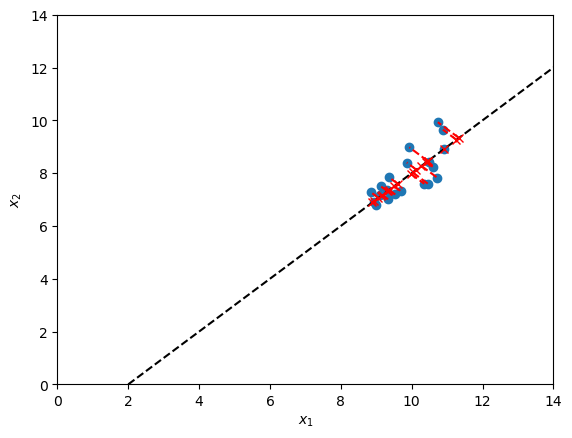

In [2]:
r=0.8
N=20
x=np.random.randn(N)+10
y=r*x+np.random.randn(N)*np.sqrt(1-r**2)

plt.plot(x,y,'o')

h = np.linspace(0,14)

plt.plot(h,h-2,'k--')

t,u = np.zeros(N),np.zeros(N)

for i in range(0,N):
    xi=x[i]; yi=y[i]
    x0=(xi+yi)/2+1
    y0=(xi+yi)/2-1
    plt.plot(x0,y0,'rx')
    plt.plot([x0,xi],[y0,yi],'r--')
    t[i] = xi
    u[i] = yi

plt.xlim([0,14])
plt.ylim([0,14])
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

## Summary 

In general, EOF analysis involves a pretty standard series of steps:

1. Remove the mean from your dataset and put it into the data matrix X (if your data is more than 1D you may need to reshape it).
2. Calculate the covariance matrix as $C = \frac{1}{M} \sum_i^{M} X^T X$.
3. Find the first L eigenvectors and eigenvalues of $C$.
4. Calculate the fraction of variance explained by each EOF.
5. Find the PC associated with the EOF by $\vec{p_i}^TX$. 

An interesting question is whether the EOFs/PCs have any kind of deeper meaning. The answer is that they only represent exactly what we derived above, the eigenvectors of the covariance matrix and the data projected onto those eigenvectors. However there are cases where the patterns identified by EOFs seem to have physical meaning. **This is not gaurenteed to happen though, and its also possible for the patterns to be meaningless**. Still, many well known patterns in the atmosphere and ocean have been found with EOFs, and they remain an important part of data analysis.



### (Some of the) challenges with PCA

- If you compute the EOFs of one field using all data in a domain, you will not get the same answer as if you compute the EOFs using only partial information. This is because 
- 

## An Example 

This example is from 
- Chen, Ge, and Xuan Wang. "Impact of domain geometry on the results of empirical orthogonal function analysis." Annals of GIS 20.3 (2014): 205-216.

It shows the PCAs of satellite precipitation calculated for a variety of different domains:

<img src="../images/EOF_Domain_Splitting.png" width=100%, height=100%>

# 4.3  - Special Example: EOFs of a diffusion equation

The example covered here is discussed in depth in 
- North, Gerald R., et al. "Sampling errors in the estimation of empirical orthogonal functions." Monthly weather review 110.7 (1982): 699-706.
And the specific proof that I do follows largely from
- Monahan, Adam H., et al. "Empirical orthogonal functions: The medium is the message." Journal of Climate 22.24 (2009): 6501-6514.

## EOFs of an SDE with a real symmetric operator and white noise forcign

- So on their own the EOFs are totally meaningless. However, there are special cases where they can be interpreted physically, but the conditions are *very* specific, to the point where its hard to imagine them happening. Still it's an interesting example that gives us a lot of insight into how EOFs and covariance work more generally. 
- So far in the multivariate SDEs we have analyzed the different elements haven't had any significance. Now we're going to pretend that we have a set of points, where at each point we have a 1D OU process with uncorrelated noise. If we let the points interact diffusively, then we have something like $$d\vec{x} = k D \vec{x} dt - \frac{1}{\tau} \vec{x} dt + B d\vec{W}$$ where $B$ is a noise strength matrix.
- Despite the fact that this is now a spatially distributed system, it's still an example of a multivariate system with gaussian noise, so all the theorems that we learned before still apply to it. In particular, the fluctuation dissipation theorem holds: $$AC+CA^T=-BB^T$$, where $C$ is the stationary covariance matrix and $A=kD-\frac{1}{\tau}I$. 
- Since $A$ is is a symmetric real matrix we know that it can be written using its eigenvalues and eigenvectors: $A=J^TLJ$, where $J^TJ=I$, e.g. $$\begin{align*}
    AC+CA^T&=&-BB^T\\
    J^TLJ C + C J^TLJ &=& - BB^T \\
    L F + F^T L &=& - J BB^T J^T  
    \end{align*}$$ where the matrix $F$ is defined by $F=JCJ^T$

- solving for $F$: $$ F_{ij} = -\frac{\left(JBB^TJ^T\right)_{ij}}{\lambda_i+\lambda_j} $$ 
- Now **if** $B=\sigma I$, then $$ F_{ij} = -\sigma^2 \frac{\left(I\right)_{ij}}{\lambda_i+\lambda_j} =  - \frac{\sigma^2}{2\lambda_i} \delta_{ij} $$So $F$ is a diagonal matrix related to the eigenvalues of $A$. 
- Now we have two expressions for $C$: $$C=J^TFJ = P^TQP$$ where $P$ and $Q$ are the eigenvector and eigenvalue matrices used before in the EOF analysis. Since $F$ and $Q$ are both diagonal, we can conclude that $J=P$, and $F=Q$. In other words, the EOFs are the eigenmodes of $A$ and the fractions of the variance explained is related to the inverse eigenvalues of A. 

- If we write the effective timescale of each mode $\tau_i=\lambda^{-1}$, then $F_i = -\frac{1}{2}\sigma^2\tau_i$, which is the same as for the 1D OU process. Importantly this means that the long timescale modes have larger variance than the short timescale modes. 

- To recap:
    1. If the linear operator $A$ is real and symmetric 
    2. And the noise has no spatial structure so that $B=\sigma I$
    3. Then the EOFs are the eigenmodes of the linear operator $A$
    4. And the decomposition of variance is given by the eigenvalues of $A$. 
- Importantly, this theorem can actually be generalized a little more, $A$ can be chosen to be the class of "normal" matrices, which is essntially defined by the Spectral matrix theorem. 
- For this very special class of system, we can actually learn the dynamics of A from the EOFs of the data.

# Sampling Rule

- A common problem when trying to interpret EOFs is to figure out where to truncate, e.g. should we look at 4 EOFs or 40? One issue is that not all the EOFs are physically meaningful. Another issue is that the covariance matrix is only an estimate of the true covariance matrix, which means that a different sample of data could produce different results. So we need to figure out whether we have enough samples in order to have a robust estimate of the EOF in question. Intuitively, we expect that the EOFs with higher eigenvalues to be better estimated, since they are a large fraction of the total variance. 
- North et. al. (2018) worked out a "rule of thumb" in order to test whether the EOFs we are studying are well resolved or not. Imagine that we have an EOF, $P_n$. The error in $P_n$ is dominated by nearby eigenmodes, e.g. $P_{n+1}$. It only makes sense to study $P_{n}$ if the sampling error in $P_n$, $\epsilon\left( P_n \right)$ is such that $\epsilon\left( P_n \right)< P_{n+1}|$, if not, then $P_n$ and $P_{n+1}$ cannot be fully distinguished. These are called "effectively degenerate modes". 

- The rule of thumb is based on a result from North et. al. 1982:$$\frac{\epsilon\left( P_n \right)}{P_{n+1}} \approx \frac{q_n}{q_{n+1}-q_n}\left(2/N\right)^{1/2} $$where $q_n$, $q_{n+1}$ are the eigenvalues. 
- Of the spacing of the eigenvalues becomes small, then the relative error in the EOF will become quite large. If the eigenvectors are orthonormal, then $|P_n| \sim 1$, so a good cutoff criteria is to use the first $n$ modes so that $\frac{q_n}{q_{n+1}-q_n}\left(2/N\right)^{1/2} \sim 1$. 
- The errors only go like $N^{-1/2}$, so the number of samples may need to be greatly increased in order to accurately sample higher eigenfunctions. 

# 4.4 Canonical Correlation Analysis (CCA)

- Suppose that we have some datasets $x$ and $y$, which each have $m$ timepoints, and $n_x$ spatial points in $x$ and $n_y$ in spatial points in $y$. To compare these two datasets we could pick any two spatial points and then compute the correlation. However, usually two spatial points will not correlate well on their own. Instead, we would like to compare linear combinations of the spatial points in $x$ and the spatial points in $y$. The point of CCA is to find the linear combinations in such a way that we maximize the correlation. 

- Suppose that we define two new variables by using linear combinations of the original data. The weights can be written as vectors $q_x$, $q_y$, although sometimes it will be easier to have normalized versions of these:

$$r_x=q^T_x  x = \hat{q}_x^T C^{-1/2}_{xx} x $$
$$r_y=q^T_y  y = \hat{q}_y^T C^{-1/2}_{yy} y $$

- The correlation between the new variables can be written 

$$\rho = \frac{r_x^T r_y }{\sqrt{r_x^T r_x}\sqrt{r_y^T r_y }}$$

- our life is a little easier if we write things using some correlation matrices:

$$R_{xy} = C^{-1/2}_{xx} C_{xy} C^{-1/2}_{yy} $$
$$R_{yx} = C^{-1/2}_{yy} C_{yx} C^{-1/2}_{xx} $$
 
- The correlation can now be written as 

$$\rho = \frac{\hat{q}_x^T R_{xy} \hat{q}_y}{ {\sqrt{ \hat{q}_x^T \hat{q}_x}\sqrt{ \hat{q}_y^T \hat{q}_y} }}$$

- We want to find $\hat{q}_x$ and $\hat{q}_y$ such that $\rho$ is maximized. We can do that by taking the derivative with respect to $\hat{q}_x$ and $\hat{q}_y$ and setting it to be 0. The details of this are a little annoying, but they can be found in the reference, and after rearranging the expressions gives the following constraints:

$$ \partial_{\hat{q}_x} \rho = 0 \implies R_{xy} R_{yx} \hat{q}_{x} = \rho^2 \hat{q}_{x} $$
$$ \partial_{\hat{q}_y} \rho = 0 \implies R_{yx} R_{xy}  \hat{q}_{y} = \rho^2 \hat{q}_{y} $$

- This resemble eigenfunction equations! In other words we will maximize $\rho$ when $\hat{q}_{x}$ are the eigenfunctions of $R_{xy} R_{yx}$ and $\hat{q}_{y}$ are the eigenfunctions of $R_{yx} R_{xy}$. 
  
- Both of these requirements can be solved using the singular value decomposition (SVD). If you're not familiar, there is a quick overview in the extra material. If we compute the SVD of $R_{xy}$:  

$$ R_{xy} = \hat{Q}_x S_{\rho} \hat{Q}^T_y $$

- Then we can calculate $R_{xy} R_{yx}:$  
$$ R_{xy} R_{yx} = \hat{Q}_x S_{\rho} \hat{Q}^T_y \hat{Q}_y S_{\rho} \hat{Q}^T_x = \hat{Q}_x S_{\rho}^2 \hat{Q}^T_x  $$
  - Similar equations hold for $\hat{Q}_y$.

- The matrices $\hat{Q}_x$ and $\hat{Q}^T_y$ play similar roles to the EOFs, however $\hat{Q}_x$ applies only to the dataset $x$ and $\hat{Q}^T_y$ applies only to the dataset $y$. A pair of vectors $\hat{q}^{i}_x$ and $\hat{q}^{i}_y$ tell us about the maximum correlation which could be found, associate with the singular value $\rho$, which is the entry (i,i) in $S_{\rho}$. 

- The time series $r_x$ and $r_y$ that can be found are called the "Cannonical Variates". They play a similar role to PCAs.

## Preconditioning and Truncation 

- CCA can often be very messy. For instance, there might be part of the domain where the signals are very weak, but which correlate very strongly with another variable. These leads to lots of noise in the results of CCA.
- One way to overcome this is to "precondition" or truncate the data using the EOFs of each dataset first, and the compute CCA. In other words we can create some truncated datasets: $$\tilde{X} = \sum_{i=1}^{n} z_{x,i} $$  $$\tilde{Y} = \sum_{i=1}^{n} z_{y,i} $$ and then take the CCA of $\tilde{X}$ and $\tilde{Y}$ instead of between $X$ and $Y$. - Precondition often will make the analysis simpler to understand, however it adds an additional parameter to the analysis, how many modes to keep in the truncation of $X$ and $Y$. There is no simple answer to picking the number of modes, typically though you look for a break or a jump in the eigenspectrum and pick the modes after that. 
  
## SVD Analysis

- The mathematical development here focused on the cross correlation matrix. However, an entirely analogous development could have been done for the cross covariance matrix, e.g. we want to find vectors $q_x$ and $q_y$ to transform our time series into $r_x = q^T_x x$ and $r_y=q^T_y y $ such that $ r_x r_y^T $ is maximized.
- The solution is exactly the same, but instead of taking the SVD of the cross correlation matrix we take the SVD of the cross covariance matrix. 
- The advantages and disadvantages to this are similar to the advantages and disadvantages of correlation and covariance. Correlation will highlight patterns better, but will include strong signals where the overall signal is weak. Covariance will miss some patterns, but will include strong signals only where the overall signal is strong. Ultimately which one you decide to use depends on the application that you have in mind. 
  
## Summary

- CCA and SVD analysis generalize the idea of PCA to data which can be off different shapes. CCA utilizes correlation, and SVD utilizes covariance. 
- To find the CCA, compute the cross correlation matrix and then take the SVD of it. 
  - The left unitary matrix will tell you about the "loadings" of the first input variable
  - The right unitary matrix will tell you about the "loadings" of the second input variable
  - These two loadings tell you about the patterns between the two datasets that create the best cross correlation.
  - Taking the projection of the time series onto the data will give you the canonical variates, similar to PCAs
- Often CCA can be messy, and so the data will be truncated using EOF analysis to a handful of eigenmodes first.

## an Example:


this figure shows the CCA loading patterns $q_x$ and $q_y$ where $x$ is taken to be the tropical pacific SSTs, and $y$ is taken to be the 500 hPA geopotential heights. The main idea was to try and find the influence of the north pacific SSTs on the position of the northern hemisphere storm tracks. Again, $q_x$ and $q_y$ were found as vectors but reshaped into maps in order to make a nice plot. Note that the first modes do not 

<img src="../images/CCA.png" width=100%, height=100%>



# 4.X

## Some notes on the diffusion equation

In a PDEs class you would derive the solutions to the diffusion equation

$$
\frac{\partial y}{\partial t} = k\frac{\partial^2 y}{\partial x^2}
$$

where $x \in \left(0,L\right)$ is a spatial dimension, and we will assume that there is no diffusion through the boundaries at 0,L. In a PDEs class you would show that the solutions to this equation can be written as 

$$  y = \sum_{n=0}^{n=\infty} \hat{y_n} sin(\lambda_n x) \exp\left(-k\lambda_n^2 t\right)  $$

where the eigenvalues are $\lambda_n = n\pi/L $. Each term is a mode corresponding to a different spatial oscillation associated with $\lambda_n$ which decays with effective timescale $\left(k\lambda_n^2\right)^{-1}$. The $\hat{y_n}$ are the amplitude of each mode, and are determined by the initial conditions. Essentially our solution is a set of decaying modes, with the larger scale spatial modes decaying slower than the smaller scale modes.

For a discretized system, we can imagine our data on at a series of grid points, spaced by some distance $dx$, $\vec{y}=\left[y_0,y_1,\dots y_{N} \right]$, where $N=L/dx$. The PDE is then replaced by an ODE

$$ \frac{dy}{dt} = k D \vec{y} $$

where $D$ is a matrix which is a finite approximation to the diffusion differential operator. In a numerics course you would derive $D$, here I will just say that $D$ effectively replaces part of $x$ by the average of its neighbors, i.e. for diffusion only,

$$y_i(t+dt)=\left(1-\frac{k dt}{dx^2}\right)y_i(t)+\frac{k dt}{dx^2}\left(\frac{y_{i+1}+y_{i-1}}{2}\right)$$ 

As an example if we imagine that $x_i$ is a local maximum/minnimum, doing this will decrease/increase $x_i$, smoothing the peak just like what we would expect diffusion to do.  

Normally if you want to solve diffusion numerically you take implicit timesteps. However because we're adding stochastic noise this isn't really going to work, so instead we're going to integrate explicitly, and I will just note that in order to have stability we need to have $dt<0.5\,dx^2/k$.

The matrix $D$ has eigenvalues $\lambda_n$ eigenvectors corresponding to the discretized versions of $\sin(\lambda_n x)$, the same as for the PDE.

Text(0.5, 1.0, 'D')

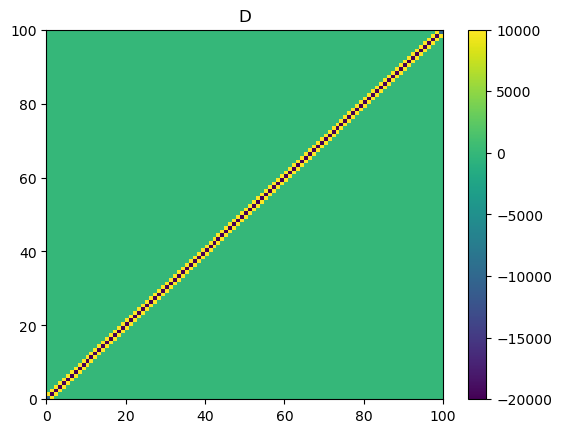

In [3]:
# heres a quick example with some diffusion.

def get_D(k,N,L):
    D = np.zeros([N,N])
    #top boundary conditions
    D[0,0]=-1; D[0,1]=1
    #most of the matrix
    for i in range(1,N-1):
        D[i,i]=-2; D[i,i-1]=1; D[i,i+1]=1;
    #bottom boundary condition
    D[-1,-1]=-1; D[-1,-2]=1
    #multiply by k/dx^2
    D*=(k/(L/N)**2)
    return D

D = get_D(1,100,1)

plt.pcolor(D); plt.colorbar(); plt.title('D')

Text(0, 0.5, 'y')

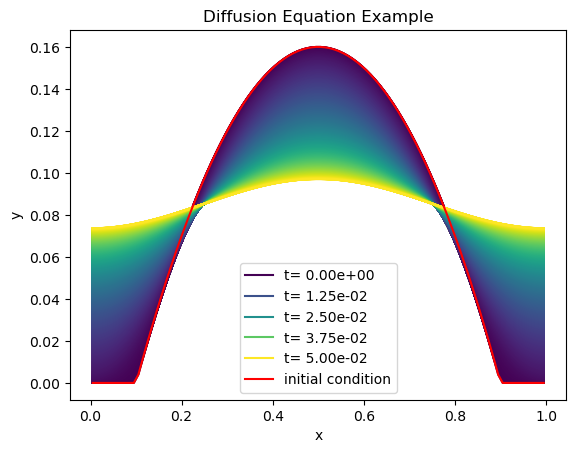

In [4]:
# do a quick example.

#define the grid and get the diffusion matrix
k=1; N=100; L=1
D=get_D(k,N,L)
dx = L/N
x=np.arange(0+0.5*dx,L,dx)

#intial condition
y0 = np.zeros(N)
y0[ (x>0.1) & (x<0.9)]=-(0.1-x[ (x>0.1) & (x<0.9)])*(0.9-x[ (x>0.1) & (x<0.9)])
dt = 0.25*dx**2/k

#container to store all the data 
M=2001
y=np.zeros([M,N])

#run the timestepping 
y[0]=y0
for i in range(0,M-1):
    y[i+1] = y[i] + dt*np.dot(D,y[i])

#make a plot
cmap=plt.cm.viridis
for i in range(0,M):
    label=None
    if i%500==0:
        label = 't=% 1.2e' % (i*dt)
    plt.plot(x,y[i],color=cmap(i/M),label=label)
plt.plot(x,y[0],'r',label='initial condition')
plt.legend()
plt.title('Diffusion Equation Example')
plt.xlabel('x'); plt.ylabel('y')

## Singular Value Decomposition (SVD)

- Suppose that $A$ is a $n_x\times n_y$ matrix. We can't diagonzalize this matrix because it isn't square. We want to define something that is like a diagonalization but that works with non-square matrices. This is the SVD.

- The SVD of $A$ is $$A= U \Lambda V^T $$ 

- The matrices $U$ and $V$ are similar to the eigenvector matrices. However, $U$ will have shape  $n_x\times n_y$, and $V$ will have shape $n_x\times n_y$. $U$ and $V$ are both unitary, i.e.:
$$UU^T=I$$
$$VV^T=I$$

- Unlike diagonalization where $\Lambda$ is a square matrix, in SVD $\Lambda will have shape $n_x \times n_y$. The values in $\Lambda$ are called the singular values. By construction these will lie along the "main diagonal" in $\Lambda$, which are entries (0,0), (1,1), etc.
- If $n_x=n_y$, then $\Lambda$ is a square matrix and the SVD reduces to diagonalization.
- If $n_x<n_y$, then $\Lambda$ looks like 
$$ \Lambda = 
\begin{pmatrix} 
\lambda_1 &  ... & 0 \\
 & \ddots &  \\
0 & ... &  \lambda_{n_x}\\
0& ... & 0  \\
& \vdots & \\
0 & ...  & 0 \\ 
\end{pmatrix} 
$$
  - If $n_x<n_y$, then $\Lambda$ looks like 
$$ \Lambda = 
\begin{pmatrix} 
\lambda_1 &  ... & 0 & 0 & ... & 0  \\
 & \ddots & & \vdots &  \\
0 & ... &  \lambda_{n_y}& 0  & ...  & 0 \\
\end{pmatrix} 
$$